# Solving the wave equation with a PINN

We aim to solve the simple 1D wave equation:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
$$

This equation can be solved analytically using separation of variables, but we aim to solve it numerically with a PINN, and check that our solution is a sinusoidal wave. To do this, we need the initial conditions:

$$
u(x, 0) = \sin(2\pi x)
$$

And the boundary conditions for boundaries $x = 0$ and $x = L$:

$$
u(0, t) = 0
$$

$$
u(L, t) = 0
$$

## Theory

The wave equation can be written in the form $F(x, t) = 0$, where:

$$
F(x, t) = \frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2}
$$

We want the neural network to learn the solution $u(x, t)$, so we make a general model `model(param, x, t)` that should converge to $u(x, t)$ after training. Thus, given our wave equation, we can define a custom loss function $L(a, x, t)$, where $a$ denotes the matrix of weights and biases:

$$
L(a, x, t) = \frac{1}{n} \sum_{i=0}^n \left( \| F(x, t) \|^2 + \| u(x, 0) - z \|^2 + \| u(0, x) - bc_1 \|^2 + \| u(L, x) - bc_2 \|^2 \right)
$$

Where $z$ denotes the initial conditions we give to the model, and $bc_1$ and $bc_2$ are the left and right boundary conditions respectively. Thus, through the same method of gradient descent, the neural network learns the function $u(x, t)$:

$$
a_{n + 1} = a_n - \gamma \nabla L(a, x, t)
$$

In [1]:
import jax
import jax.numpy as jnp
from jax import jit, grad, vmap
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def softplus(x):
    return jnp.log(1 + jnp.exp(x))

In [225]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

In [226]:
samples = 500

In [227]:
x = jnp.linspace(0, 1, samples)
t = jnp.linspace(0, 1, samples)

In [228]:
initial = jnp.sin(2 * jnp.pi * x)
zeros = jnp.zeros(samples)
ones = jnp.ones(samples)
bc = zeros

We create a basic model that takes 2 inputs ($x$ and $t$) and returns a single scalar output:

In [648]:
# def initialize_weights(layer_sizes, seed, w_min=-1.0, w_max=1.0):
#     params = []
    
#     # for first layer we just need 2 numbers
#     w0 = jax.random.uniform(key=seed)
#     b0 = jax.random.uniform(key=seed)
#     params.append([w0, b0])

#     for i, units in enumerate(layer_sizes):
#         if i==0:
#             w = jax.random.uniform(key=seed, shape=(units, 1), minval=w_min, maxval=w_max)
#         else:
#             w = jax.random.uniform(key=seed, shape=(units, layer_sizes[i-1]), minval=w_min, maxval=w_max)
#         b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(units,), dtype=jnp.float32)
#         params.append([w,b])

#     return params

In [649]:
# def linear_layer(weights, input_data, activation=lambda x: x, debug=False):
#     w, b = weights
#     out = jnp.dot(input_data, w.T) + b
#     if debug:
#         print("Output shape:", out.shape)
#         print(out)
#     return activation(out)

In [650]:
# # model to be used to learn u(x, t)
# def model(params, x, t):
#     layer_out = x * params[0][0] + t * params[0][1]
    
#     for i in range(len(params[:-1])):
#         layer_out = linear_layer(params[i], layer_out, activation=softplus, debug=False)
    
#     preds = linear_layer(params[-1], layer_out, debug=False)
    
#     return jnp.sum(preds) # since there is only one element this just squeezes array

In [ ]:
# # Despite having more layers this version of the model
# # actually performs worse, I'm not sure why
# def model_v2(params, x, t, activation=softplus):
#     # Layer sizes (including input + output): 2, 200, 200, 1
#     wx = params[:200] # x weights
#     wt = params[200:400] # t weights
#     b0 = params[400:600]
#     w1 = params[600:800]
#     b1 = params[800:1000]
#     w2 = params[1000:1200]
#     b2 = params[1200:1400]
#     w3 = params[1400:1600]
#     b3 = params[1600]
#     # layers
#     l1 = activation(x * wx + t * wt + b0)
#     l2 = activation(l1 * w1 + b1)
#     l3 = activation(l2 * w2 + b2)
#     o = jnp.sum(l3 * w3) + b3
#     return o

In [119]:
#layer_sizes = [5,10,15,1]

In [120]:
#params = initialize_weights(layer_sizes, key)

In [242]:
key = jax.random.PRNGKey(0)

In [243]:
params = jax.random.normal(key, shape=(401,))

In [245]:
# Model with basic sigmoid activation to represent the
# scalar-valued function u(x, t)
# The model has just one input and one output layer
def model(params, x, t, activation=softplus):
    wx = params[:100] # x weights
    wt = params[100:200] # t weights
    b0 = params[200:300]
    w1 = params[300:400]
    b2 = params[400]
    l1 = activation(x * wx + t * wt + b0)
    o = jnp.dot(w1, l1) + b2
    return o

In [246]:
df_2dx_2 = grad(grad(model, 1), 1) # ∂^2f / ∂x^2
df_2dt_2 = grad(grad(model, 2), 2) # ∂^2f / ∂t^2

In [247]:
model_vect = jit(vmap(model, (None, 0, 0)))
df_2dx_2_vect = jit(vmap(df_2dx_2, (None, 0, 0)))
df_2dt_2_vect = jit(vmap(df_2dt_2, (None, 0, 0)))

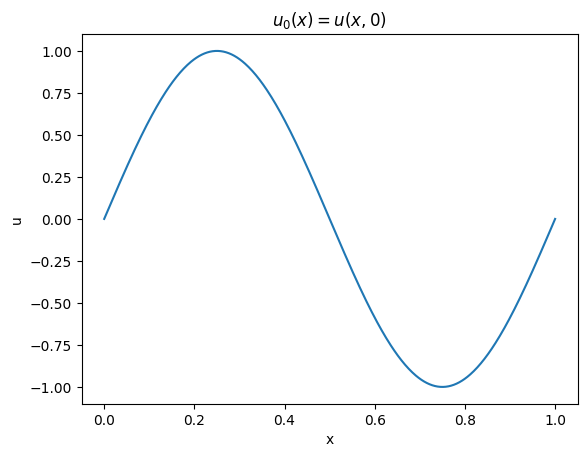

In [215]:
plt.plot(x, initial)
plt.title(r"$u_0(x) = u(x, 0)$")
plt.xlabel("x")
plt.ylabel("u")
plt.show()

In [248]:
# The PDE (what we refer to as F(x, t))
@jit
def pde(params, x, t, c=1):
    # ∂^2f / ∂t^2 - c^2 (∂^2f / ∂x^2)
    return df_2dt_2_vect(params, x, t) - \
        c ** 2 * df_2dx_2_vect(params, x, t)

In [249]:
def loss(params, x, t, initial=initial, zeros=zeros, bc=bc, ones=ones):
    eq_loss = pde(params, x, t)
    initial_cond_loss = model_vect(params, x, zeros) - initial
    bc_left_loss = model_vect(params, zeros, t) - bc
    bc_right_loss = model_vect(params, ones, t) - bc
    return jnp.mean(eq_loss ** 2) \
            + jnp.mean(initial_cond_loss ** 2) \
            + jnp.mean(bc_left_loss ** 2) \
            + jnp.mean(bc_right_loss ** 2)

In [250]:
loss_grad = jit(grad(loss, 0))

In [251]:
epochs = 20000 #7000
lr = 1e-3

In [252]:
for epoch in range(epochs):
    if epoch % 100  == 0:
        print(f"Epoch: {epoch} loss: {loss(params, x, t)}")
    gradient = loss_grad(params, x, t)
    params -= lr * gradient
    # This is for the multilayer version
#     for i in range(0, len(gradient)):
#         for j in range(0, len(layer_grad)):
#             params[i][j] -= lr * gradient[i][j]

Epoch: 0 loss: 37.66064453125
Epoch: 100 loss: 1.104752540588379
Epoch: 200 loss: 0.9578067660331726
Epoch: 300 loss: 0.8505733013153076
Epoch: 400 loss: 0.7684671878814697
Epoch: 500 loss: 0.7039772272109985
Epoch: 600 loss: 0.6524386405944824
Epoch: 700 loss: 0.6107577681541443
Epoch: 800 loss: 0.5767643451690674
Epoch: 900 loss: 0.5488680005073547
Epoch: 1000 loss: 0.525863528251648
Epoch: 1100 loss: 0.5068156123161316
Epoch: 1200 loss: 0.49098724126815796
Epoch: 1300 loss: 0.4777894616127014
Epoch: 1400 loss: 0.46674877405166626
Epoch: 1500 loss: 0.4574815630912781
Epoch: 1600 loss: 0.4496762752532959
Epoch: 1700 loss: 0.44307807087898254
Epoch: 1800 loss: 0.43747901916503906
Epoch: 1900 loss: 0.4327085018157959
Epoch: 2000 loss: 0.4286261796951294
Epoch: 2100 loss: 0.42511600255966187
Epoch: 2200 loss: 0.42208316922187805
Epoch: 2300 loss: 0.41944897174835205
Epoch: 2400 loss: 0.41714853048324585
Epoch: 2500 loss: 0.41512739658355713
Epoch: 2600 loss: 0.413341224193573
Epoch: 2700

In [253]:
t0 = jnp.zeros(samples)

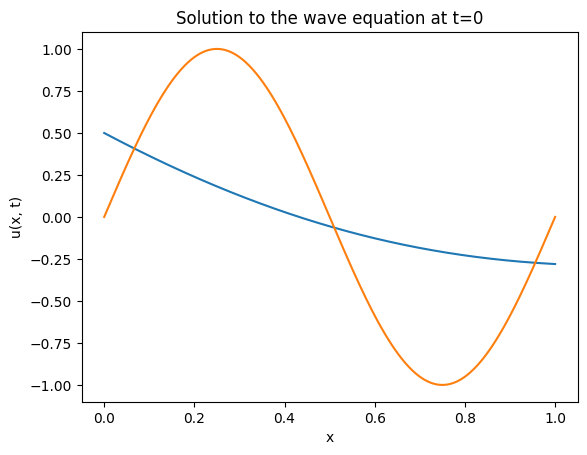

In [254]:
# Plotting the solution at t=0
plt.plot(x, model_vect(params, x, t0))
plt.title("Solution to the wave equation at t=0")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.plot(x, initial)
plt.show()

In [134]:
t3 = jnp.full(samples, 0.5)

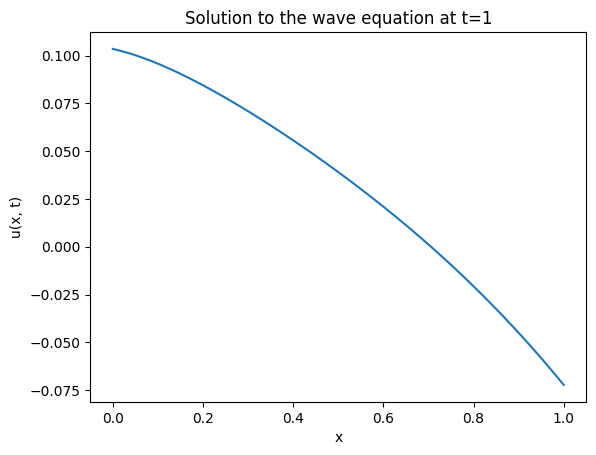

In [135]:
# Plotting the solution at t=1
plt.plot(x, model_vect(params, x, t3))
plt.title("Solution to the wave equation at t=1")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.show()

In [24]:
import numpy as np

In [25]:
def cart_prod(*arrs):
    """ Get array of cartesian tuples from arbitrary number of arrays.
    """
    grids = np.meshgrid(*arrs, indexing='ij')
    return np.stack(grids, axis=-1).reshape(-1, len(arrs))

In [26]:
X, T = np.meshgrid(x, t)

In [27]:
grid = cart_prod(x, t)

In [28]:
grid.shape

(250000, 2)

In [33]:
approximations = model_vect(params, grid[:, 0:1], grid[:, 1:2]).reshape((samples, samples))

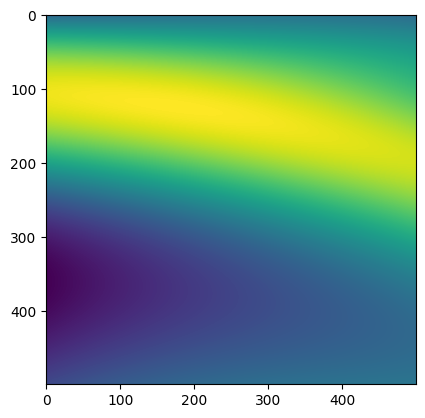

In [35]:
plt.imshow(approximations)
plt.show()

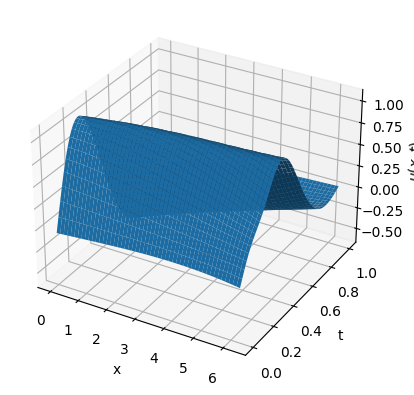

In [38]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(X, T, approximations)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel(r"$u(x, t)$")
plt.show()

$$
u(x, t) = A\sin(x - vt) + B \sin(x + vt)
$$